In [1]:
# Предобработка данных и обучение KNN модели для предсказания цены на недвижимость

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

data = pd.read_csv('/kaggle/input/house-price/melb_data.csv')
data

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [2]:
X = data.drop(columns='Price')
y = data['Price']

In [3]:
X

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


Поле `Metchod` является ликом, убираем его.

In [4]:
X = X.drop(columns='Method')

In [5]:
X.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [6]:
X.loc[X['Car'].isna(), 'Car'] = X['Car'].mean()

In [7]:
X = X.drop(columns=['BuildingArea', 'CouncilArea'])

In [8]:
X['YearBuiltWasMissing'] = X['YearBuilt'].isna()
X.loc[X['YearBuilt'].isna(), 'YearBuilt'] = X['YearBuilt'].mean()

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Suburb               13580 non-null  object 
 1   Address              13580 non-null  object 
 2   Rooms                13580 non-null  int64  
 3   Type                 13580 non-null  object 
 4   SellerG              13580 non-null  object 
 5   Date                 13580 non-null  object 
 6   Distance             13580 non-null  float64
 7   Postcode             13580 non-null  float64
 8   Bedroom2             13580 non-null  float64
 9   Bathroom             13580 non-null  float64
 10  Car                  13580 non-null  float64
 11  Landsize             13580 non-null  float64
 12  YearBuilt            13580 non-null  float64
 13  Lattitude            13580 non-null  float64
 14  Longtitude           13580 non-null  float64
 15  Regionname           13580 non-null 

In [10]:
categorical_cols = [
    'Suburb',
    'Type',
    'Regionname',
    'YearBuiltWasMissing'
]

numerical_cols = [
    'Rooms',
    'Distance',
    'Bedroom2',
    'Bathroom',
    'Car',
    'Landsize',
    'YearBuilt',
    'Lattitude',
    'Longtitude',
    'Propertycount'
]

cols_to_drop = [
    'Address',
    'SellerG',
    'Date',
    'Postcode'
]

In [11]:
suburb_counts = X['Suburb'].value_counts()
suburb_counts

Suburb
Reservoir         359
Richmond          260
Bentleigh East    249
Preston           239
Brunswick         222
                 ... 
Sandhurst           1
Bullengarook        1
Croydon South       1
Montrose            1
Monbulk             1
Name: count, Length: 314, dtype: int64

In [12]:
is_rare_suburb = X['Suburb'].apply(lambda x: suburb_counts[x] < 200)
X.loc[is_rare_suburb, 'Suburb'] = 'RareSuburb'

In [13]:
X = X.drop(columns=cols_to_drop)

In [14]:
X = pd.get_dummies(X, columns=categorical_cols)
X

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Propertycount,...,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,YearBuiltWasMissing_False,YearBuiltWasMissing_True
0,2,2.5,2.0,1.0,1.0,202.0,1964.684217,-37.79960,144.99840,4019.0,...,False,False,True,False,False,False,False,False,False,True
1,2,2.5,2.0,1.0,0.0,156.0,1900.000000,-37.80790,144.99340,4019.0,...,False,False,True,False,False,False,False,False,True,False
2,3,2.5,3.0,2.0,0.0,134.0,1900.000000,-37.80930,144.99440,4019.0,...,False,False,True,False,False,False,False,False,True,False
3,3,2.5,3.0,2.0,1.0,94.0,1964.684217,-37.79690,144.99690,4019.0,...,False,False,True,False,False,False,False,False,False,True
4,4,2.5,3.0,1.0,2.0,120.0,2014.000000,-37.80720,144.99410,4019.0,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,16.7,4.0,2.0,2.0,652.0,1981.000000,-37.90562,145.16761,7392.0,...,False,False,False,False,True,False,False,False,True,False
13576,3,6.8,3.0,2.0,2.0,333.0,1995.000000,-37.85927,144.87904,6380.0,...,False,False,False,False,False,False,True,False,True,False
13577,3,6.8,3.0,2.0,4.0,436.0,1997.000000,-37.85274,144.88738,6380.0,...,False,False,False,False,False,False,True,False,True,False
13578,4,6.8,4.0,1.0,5.0,866.0,1920.000000,-37.85908,144.89299,6380.0,...,False,False,False,False,False,False,True,False,True,False


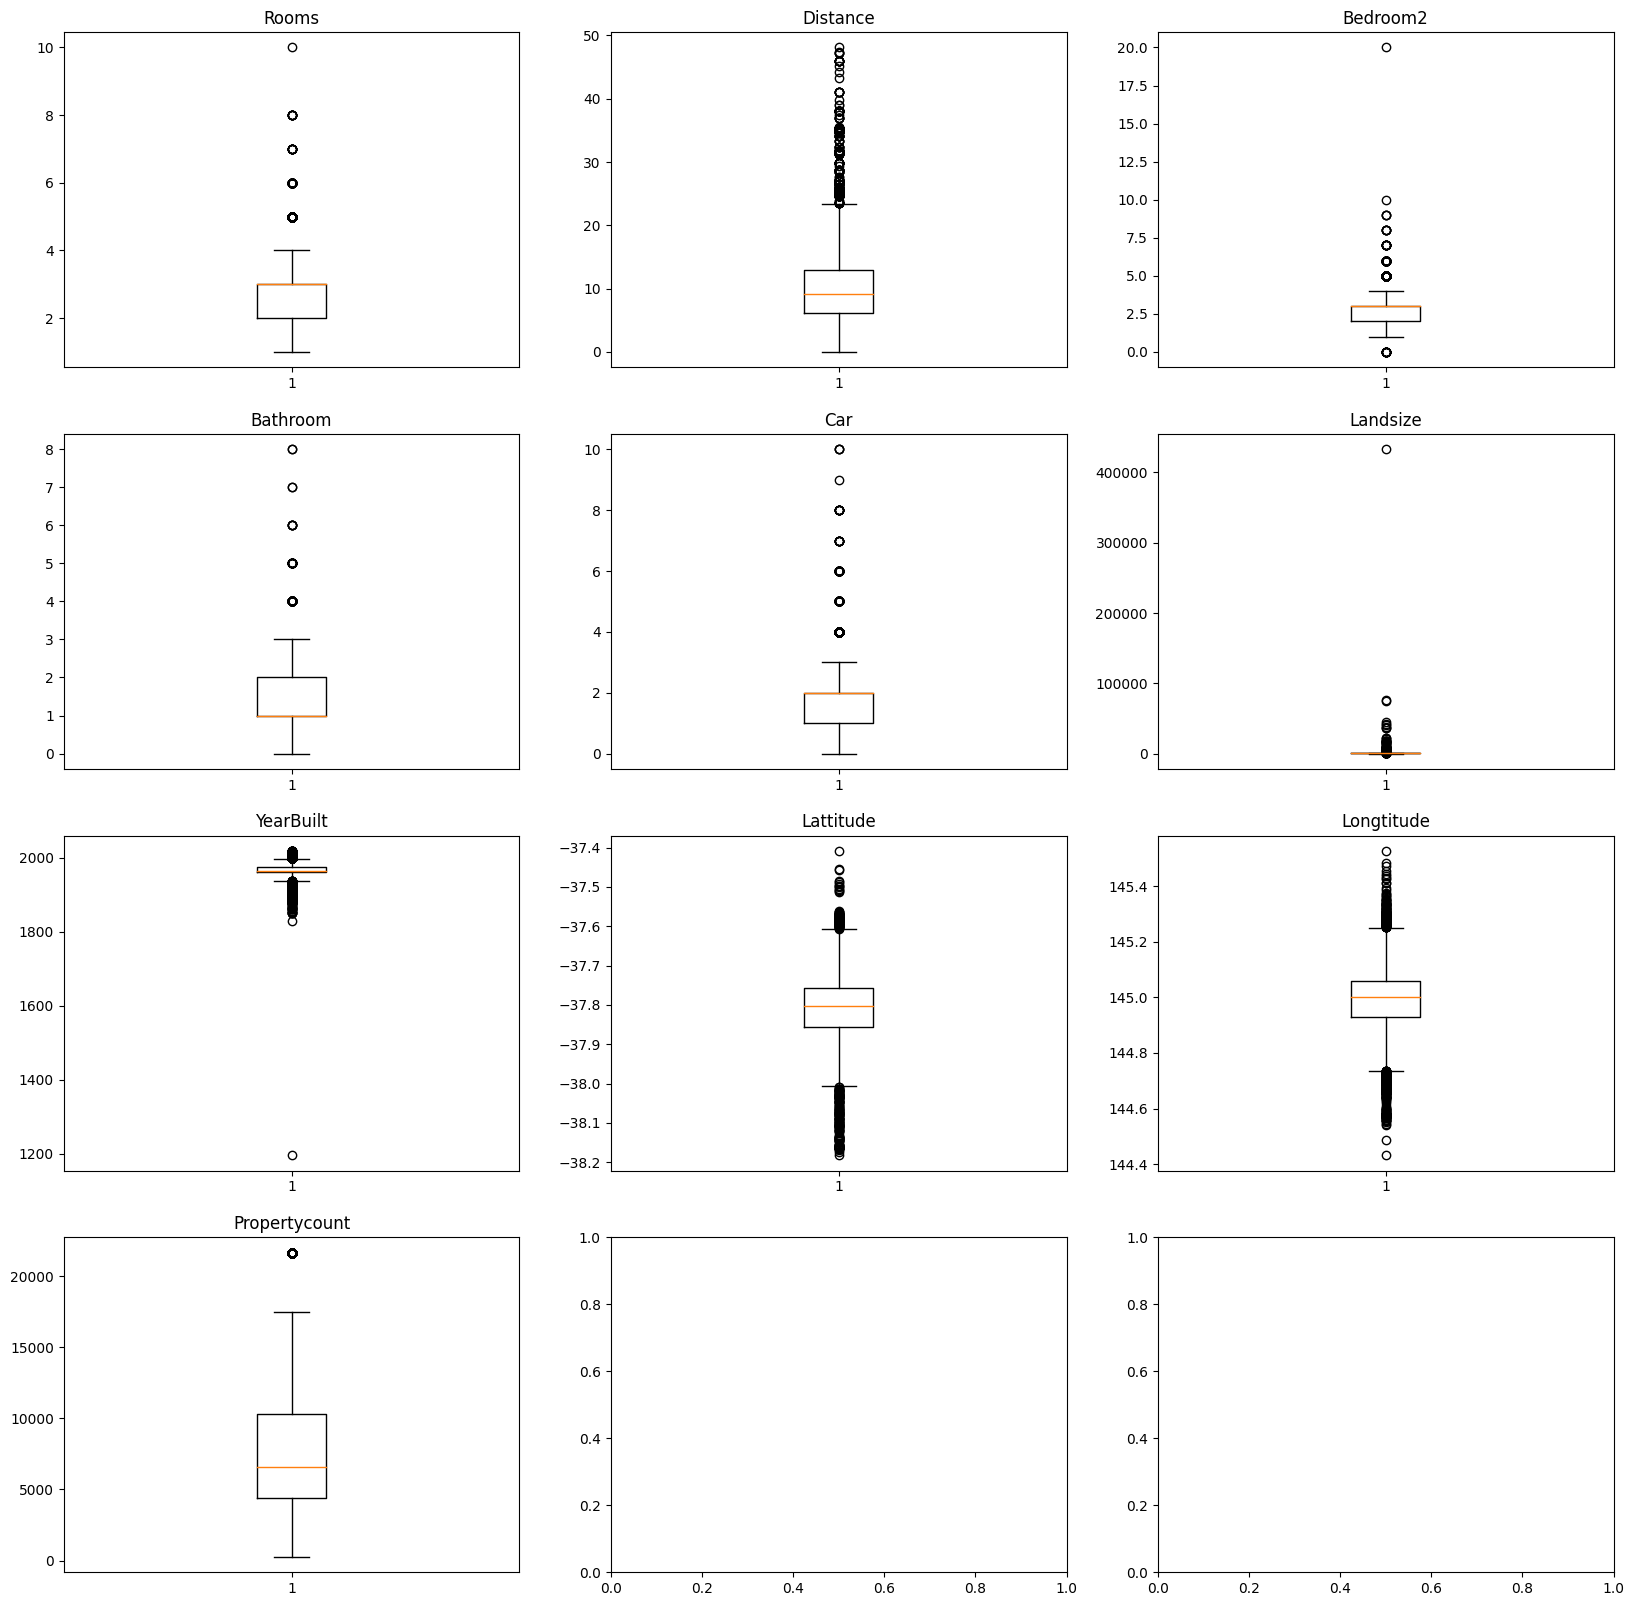

In [15]:
for ax, col_name in zip(plt.subplots(4, 3, figsize=(20, 20))[1].flatten(), numerical_cols):
    ax.set_title(col_name)
    ax.boxplot(X[col_name])

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
knn = KNeighborsRegressor(5)
cv = KFold(n_splits=5)
errors = []

for train_idx, val_idx in cv.split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    knn.fit(X_train, y_train)
    pred_val = knn.predict(X_val)
    errors.append(
        mean_squared_error(y_val, pred_val)
    )
    
print('Metrics')
print(errors)
print('RMSE=', np.mean(errors) ** 0.5)

Metrics
[152217947755.374, 139816382680.09613, 151517859886.62695, 125179488503.45377, 140351366344.85535]
RMSE= 376585.46046559105


In [18]:
scores = cross_val_score(knn, X, y, cv=5)
scores

array([0.65408053, 0.67063013, 0.64918479, 0.63602139, 0.63816684])

In [19]:
scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred), greater_is_better=True)
errors = cross_val_score(knn, X, y, cv=5, scoring=scorer)

print('Metrics')
print(errors)
print('RMSE=', np.mean(errors) ** 0.5)

Metrics
[1.52217948e+11 1.39816383e+11 1.51517860e+11 1.25179489e+11
 1.40351366e+11]
RMSE= 376585.46046559105
